# Introduction to Machine Learning

## Practice class 11 - Genetical algorithm

**Introduction**

Genetic algorithms are a class of optimization algorithms inspired by the process of natural selection. They are used to find approximate solutions to complex problems by mimicking the process of evolution.

In this practice class, we will implement a simple genetic algorithm to play the game of Snake.

**Key concepts**
- Genetic algorithm
- Population: A group of potential solutions (individuals)
- Crossover: Combining genes from two parents to create offspring
- Mutation: Randomly changing genes in a chromosome
- Score/fitness: A measure of how well an individual performs in the environment (e.g. time alive)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')

# Snake game

### Task 1: Look at the code of the snake game

In [19]:
#global variables 
#empty place is 0
CHERRY = 1 #cherry
WALL = 2 #wall
SN_HEAD = 3 #haed of snake /only for drawing
SN = 4 #snake
dir = np.array([[0,1], [-1,0], [0,-1], [1,0]]) #directions

In [3]:
def clear(g):	#clear the grid
    g *= 0
    L = len(g)
    for a in range(L):
        g[a,0] = WALL
        g[a,L-1] = WALL
        g[0,a] = WALL
        g[L-1,a] = WALL

In [4]:
def add_cherry(g):	#add a cherry to a random empty space
    zero = np.where(g==0)
    r = np.random.randint(len(zero[0]))
    g[zero[0][r]][zero[1][r]] = CHERRY

In [5]:
def add_snake(g,snake):	#add snake to the grid
	g[snake[0][0], snake[0][1]] = SN_HEAD
	for s in snake[1:]:
		g[s[0],s[1]] = SN

In [6]:
def check_head(g, snake, ir):	#check if the snake head is on a cherry or wall
    head = np.array(snake[0])
    head += dir[ir]
    return g[head[0]][head[1]]

In [7]:
def move_snake(g, snake, ir, cherry): #move the snake
    head = np.array(snake[0])
    g[head[0],head[1]] = SN
    head += dir[ir]
    g[head[0],head[1]] = SN_HEAD
    snake.insert(0,list(head))
    
    if not cherry: # if no cherry, remove the tail
        tail = snake.pop()
        g[tail[0],tail[1]] = 0

### Predict movement

Input $\underline{\underline{M}}$ - (8, 1)
- first four: wether we can move in direction (0 or 1)
- last four: is charry in direction (0 or 1)

Weights $\underline{\underline{W}}$- (8, 4)
- $\bold{genes}$ of a snake

Output $\underline{\underline{O}}$ - (4, 1)
- movement propability of snake (up, down, left, right)
- $\underline{\underline{O}} = softmax(\underline{\underline{M}} \cdot \underline{\underline{W}})$

In [8]:
def get_input(g,snake):
    cherry = np.where(g == CHERRY)
    c = np.array([cherry[0][0],cherry[1][0]])
    data = np.zeros(8,dtype=int)
    #first four is wether we can go in that direction
    for i in range(4):
        data[i] = check_head(g,snake,i) < 2
    #next four if the cherry is in that direction
    head = np.array(snake[0])
    for i in range(4):
        data[4 + i] = np.dot(dir[i],c - head) > 0
    return(data)

def get_output(W,X):
    return 1.0 / (1.0 + np.exp(np.dot(X,W)))

### Run a game with given size, genes and steps

Calculate score of the snake: time alive

In [9]:
def full_run(L,W,maxstep,save):
    #create snake
    L2 = int(L/2)
    snake = [[L2,L2],[L2,L2+1],[L2+1,L2+1]]
    
	#initialise game
    g = np.zeros((L,L), dtype=int) 
    clear(g) 
    add_snake(g,snake)
    add_cherry(g)
    score = 0
    save.append(np.copy(g))

	#run steps
    for i in range(maxstep):
        nd = get_output(W,get_input(g,snake)).argmax() #get preditcion
        ahead = check_head(g, snake, nd) 
        eat = False
        if ahead == CHERRY: #food
            score += 10
            eat = True
        elif ahead >= 2: #collision
            score -= 5
            return score + min(10, int(i / 5))
        
        move_snake(g,snake,nd,eat) 
        
        if eat:
            add_cherry(g)
            
        save.append(np.copy(g)) #save for antimation
    return(score + min(10, int(i / 5))) #return score

### Initialise a game

In [10]:
snake = [[10,10],[10,11],[11,11]] #snake with x-y coordinates
g = np.zeros((20,20),dtype=int) #empty board
clear(g) #add walls to board
add_snake(g,snake) #add snake to board
add_cherry(g) #add one cherry
W = np.random.normal(0,1.0,(8,4)) #random genes

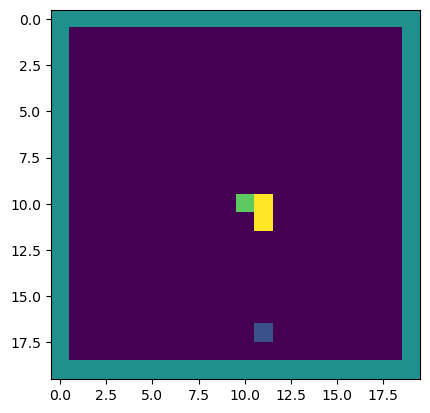

In [11]:
plt.imshow(g);

### Run a game

In [12]:
W = np.random.normal(0,1.0,(8,4))
save = []
score = full_run(20,W,1000, save)
print(score, len(save))

-4 10


### Create animation from the game

In [13]:
#Help function for animation
def anim_snake(save):
    fig = plt.figure()
    ims = []
    for s in save:
        im = plt.imshow(s, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)
    plt.show()
    return ims

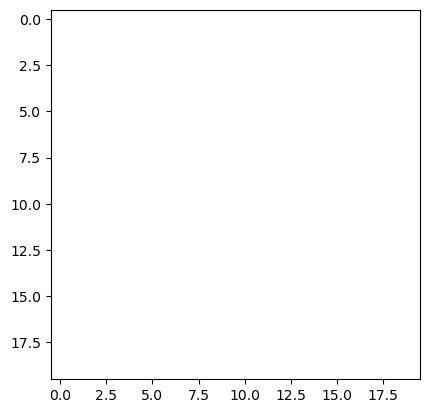

In [14]:
fig = plt.figure()
ims = []
for s in save:
    im = plt.imshow(s, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)

In [15]:
ani

## Task 2: Teach computer to play snake using genetic algorithm

1. Create a population of 100 genes ((8,4) random matrices with zero mean, unit variance)
2. Make a loop for generations(~ 60-70 is enough, sart with smaller)
- for each gene run a game and save the scores
- find the best performing 50%
- create new genes by crossover and replace the worst 50% with the new ones:
	- get 2 parents from the best half $\underline{\underline{W_A}}$, $\underline{\underline{W_B}}$
	- create a child by combining the parts of weights of the parents
		- randomly choose part of $\underline{\underline{W_A}}$ from a parent
		- fill the rest with $\underline{\underline{W_B}}$
		- $\underline{\underline{W_C}}$ = $\underline{\underline{W_A}}\cdot \underline{\underline{P}}$ + $\underline{\underline{W_B}} \cdot (1 - \underline{\underline{P}})$, where $\underline{\underline{P}}$ is a random mask matrix of the same size (8, 4)
- mutation
	- modifiy each value of gene with a small probability (e.g. 0.001)
3. Plot the score of the best performing gene in each generation
4. Animate the best gene of the last generation



In [20]:
generations = 70

popsize = 100
worst = 50
np.random.seed(42)
# create a population of random weights
population = np.random.normal(loc=0.0,scale=1.0,size=(popsize,8,4))

for i in range(generations):
    scores = []
    for j in range(popsize):
        save = []
        score = full_run(20,population[j],500,save)
        scores.append(score)
    scores = np.array(scores)
    # get the indices of the best scores
    bestind = np.argsort(scores)
    #cross over
    for j in range(worst):
        parents = np.random.choice(bestind[worst:],2,replace=False)
        mask = np.random.choice([0,1],size=(8,4))
        child = np.where(mask, population[parents[0]], population[parents[1]])
        #mutate
        child += np.where(np.random.rand(8,4) < 0.01, np.random.normal(0,1,(8,4)), 0)
        population[bestind[j]] = child
    #save best
    W = population[bestind[-1]]
    save = []
    score = full_run(20,W,500,save)
    print(score, len(save))


-1 25
-4 10
-2 20
-2 16
-5 2
11 32
7 13
10 501
10 501
-5 1
1 35
-2 16
20 501
-2 18
10 501
0 26
10 501
20 501
25 78
10 501
90 501
55 88
13 41
250 501
115 292
24 49
105 221
55 203
225 381
85 183
35 71
45 82
75 204
65 156
55 120
85 177
33 44
55 101
125 247
45 117
20 501
75 107
25 97
165 243
75 84
55 81
145 215
195 281
135 263
75 221
235 449
275 487
7 13
75 186
95 166
260 501
115 142
260 501
155 243
5 3
245 411
295 494
195 414
250 501
260 501
75 124
215 365
185 230
250 501
85 182


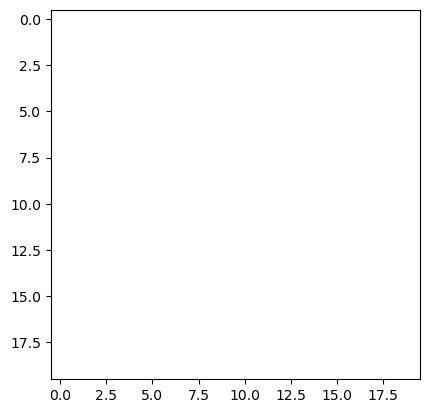

In [21]:
fig = plt.figure()
ims = []
for s in save:
    im = plt.imshow(s, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)

In [22]:
ani

# Homework - Solve a maze with genetic algorithm

- Create a maze with the size of your choice (e.g. 20x20).
- Create agents with local vision(only the cells around them).
- Solve the maze with genetic algorithm.
- Visualise the maze and the agents.

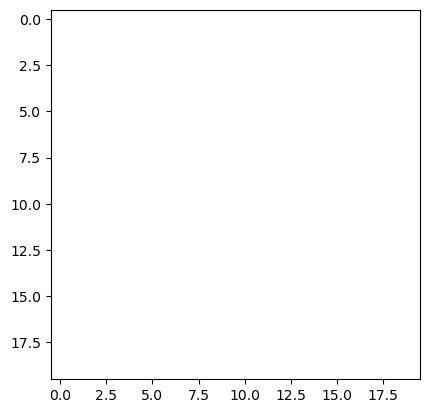

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import random

EMPTY, WALL, START, GOAL, AGENT = 0, 1, 2, 3, 4
DIRS = np.array([[0, 1], [-1, 0], [0, -1], [1, 0]]) 

def create_maze(size):
    maze = np.zeros((size, size), dtype=int)
    maze[0,:] = maze[:,0] = maze[-1,:] = maze[:,-1] = WALL
    for _ in range(size * size // 5):
        x, y = np.random.randint(1, size-1, 2)
        maze[x,y] = WALL
    sx, sy = 1, 1
    gx, gy = size-2, size-2
    maze[sx, sy] = START
    maze[gx, gy] = GOAL
    return maze, (sx, sy), (gx, gy)


def get_vision(maze, pos):
    x, y = pos
    vis = maze[x-1:x+2, y-1:y+2].flatten()
    return vis / 4.0  # normalize input values

def predict_move(genome, vision):
    w = genome.reshape((9, 4))
    scores = vision @ w  
    return np.argmax(scores) 


def run_agent(maze, genome, start, goal, max_steps=100):
    path = [start]
    pos = np.array(start)
    visited_map = np.zeros_like(maze, dtype=int)
    visited_map[tuple(pos)] = 1
    score = 0
    last_positions = []

    for step in range(max_steps):
        vision = get_vision(maze, pos)
        move_idx = predict_move(genome, vision)
        move = DIRS[move_idx]
        new_pos = pos + move

        if maze[new_pos[0], new_pos[1]] == WALL:
            score -= 5
            continue

        pos = new_pos
        path.append(tuple(pos))

        dist = np.linalg.norm(np.array(goal) - pos)
        score += 2.0 / (dist + 1.0)

        # Penalize revisiting the same places
        visit_count = visited_map[tuple(pos)]
        score -= visit_count * 0.7  # gradually increasing penalty
        visited_map[tuple(pos)] += 1

        # Loop detection: if stuck in same recent places
        last_positions.append(tuple(pos))
        if len(last_positions) > 6:
            last_positions.pop(0)
        if len(set(last_positions)) <= 2:
            score -= 10  # penalize being stuck

        if maze[pos[0], pos[1]] == GOAL:
            score += 1000 - step 
            break

    return score, path


def genetic_maze_solver(generations=50, pop_size=100, maze_size=20):
    maze, start, goal = create_maze(maze_size)
    population = np.random.randn(pop_size, 9*4) 

    best_path = []
    best_score = -np.inf

    for gen in range(generations):
        scores_paths = [run_agent(maze, genome, start, goal) for genome in population]
        scores = np.array([s for s, _ in scores_paths])
        paths = [p for _, p in scores_paths]

        top_idx = scores.argsort()[-pop_size//2:]
        best_gen_score = scores[top_idx[-1]]
        if best_gen_score > best_score:
            best_score = best_gen_score
            best_path = paths[top_idx[-1]]

        new_pop = []
        for _ in range(pop_size):
            p1, p2 = population[np.random.choice(top_idx, 2, replace=False)]
            mask = np.random.rand(9*4) < 0.5
            child = np.where(mask, p1, p2)
            mutation = np.random.rand(9*4) < 0.05
            child += mutation * np.random.randn(9*4) * 0.5
            new_pop.append(child)
        population = np.array(new_pop)
        print(f"Generation {gen+1}: Best Score = {best_gen_score:.2f}")

    return maze, best_path

def animate_maze(maze, path):
    maze_display = np.copy(maze)
    fig, ax = plt.subplots()
    ims = []

    for pos in path:
        maze_display = np.copy(maze)
        maze_display[pos] = AGENT
        im = ax.imshow(maze_display, cmap='nipy_spectral', animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True)
    plt.show()
    return ani

#maze, best_path = genetic_maze_solver()
animate_maze(maze, best_path)
